## inception Block 的结构实现
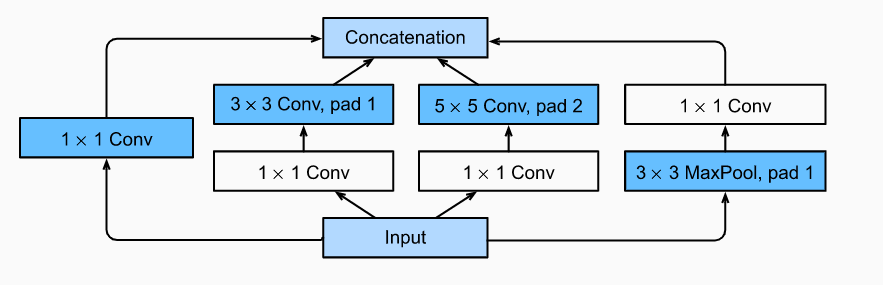

In [1]:
import torch.nn as nn

In [2]:
# GoogleNet中的Inception Block的定义
class InceptionModule(nn.Module):
    def __init__(self, input_planes, n_channels1x1, n_channels3x3red, n_channels3x3, n_channels5x5red, n_channels5x5, pooling_planes):
        super(InceptionModule, self).__init__()
        # 1x1 卷积分支
        self.block1 = nn.Sequential(
            nn.Conv2d(input_planes, n_channels1x1, kernel_size=1),
            nn.BatchNorm2d(n_channels1x1),
            nn.ReLU(True),
        )
 
        # 1x1 卷积 -> 3x3 卷积分支
        self.block2 = nn.Sequential(
            nn.Conv2d(input_planes, n_channels3x3red, kernel_size=1),
            nn.BatchNorm2d(n_channels3x3red),
            nn.ReLU(True),
            nn.Conv2d(n_channels3x3red, n_channels3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_channels3x3),
            nn.ReLU(True),
        )
 
        # 1x1 卷积 -> 5x5 卷积分支
        self.block3 = nn.Sequential(
            nn.Conv2d(input_planes, n_channels5x5red, kernel_size=1),
            nn.BatchNorm2d(n_channels5x5red),
            nn.ReLU(True),
            nn.Conv2d(n_channels5x5red, n_channels5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_channels5x5),
            nn.ReLU(True),
            nn.Conv2d(n_channels5x5, n_channels5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_channels5x5),
            nn.ReLU(True),
        )
 
        # 3x3 池化 -> 1x1 卷积分支
        self.block4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(input_planes, pooling_planes, kernel_size=1),
            nn.BatchNorm2d(pooling_planes),
            nn.ReLU(True),
        )
 
    def forward(self, ip):
        op1 = self.block1(ip)
        op2 = self.block2(ip)
        op3 = self.block3(ip)
        op4 = self.block4(ip)
        # 最后的整合
        return torch.cat([op1,op2,op3,op4], 1)

## GoogleNet 模型的定义

In [3]:
class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )
 
        self.im1 = InceptionModule(192,  64,  96, 128, 16, 32, 32)
        self.im2 = InceptionModule(256, 128, 128, 192, 32, 96, 64)
 
        self.max_pool = nn.MaxPool2d(3, stride=2, padding=1)
 
        self.im3 = InceptionModule(480, 192,  96, 208, 16,  48,  64)
        self.im4 = InceptionModule(512, 160, 112, 224, 24,  64,  64)
        self.im5 = InceptionModule(512, 128, 128, 256, 24,  64,  64)
        self.im6 = InceptionModule(512, 112, 144, 288, 32,  64,  64)
        self.im7 = InceptionModule(528, 256, 160, 320, 32, 128, 128)
 
        self.im8 = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.im9 = InceptionModule(832, 384, 192, 384, 48, 128, 128)
 
        self.average_pool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(4096, 1000)
 
    def forward(self, ip):
        op = self.stem(ip)
        out = self.im1(op)
        out = self.im2(op)
        op = self.maxpool(op)
        op = self.im3(op)
        op = self.im4(op)
        op = self.im5(op)
        op = self.im6(op)
        op = self.im7(op)
        op = self.max_pool(op)
        op = self.im8(op)
        op = self.im9(op)
        op = self.avgerage_pool(op)
        op = op.view(op.size(0), -1)
        op = self.fc(op)
        return op

In [ ]:
# 除了自己定义和实例化GoogleNet模型外，我们也能够直接引用预训练好的模型
import torchvision.models as models

model = models.googlenet(pretrained=True)